In [1]:
from hybra import HybrA
import soundfile
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.nn import functional as F

from hybra.utils import calculate_condition_number, fir_tightener3000, fir_tightener4000, random_filterbank

In [2]:
# test signal

x, fs = soundfile.read("signal.wav")
N = 5*fs
x = torch.tensor(x[:N,0], dtype=torch.float32)[None,...]
x.shape

torch.Size([1, 80000])

In [9]:
# tight auditory filterbank

aud_real = torch.load("auditory_filters_speech.pth", map_location="cpu")['auditory_filters_real']
aud_imag = torch.load("auditory_filters_speech.pth", map_location="cpu")['auditory_filters_imag']
aud = torch.tensor(aud_real + 1j * aud_imag, dtype=torch.complex64)
aud = aud.squeeze()

J = aud.shape[0]
T = aud.shape[-1]

aud_pad = torch.cat([aud, torch.zeros(J,N-T)], dim=1)
aud_tight = fir_tightener3000(aud_pad.squeeze(), 512, eps=1.01)
aud_tight_fir = aud_tight[:, :T]

print(calculate_condition_number(aud_tight))

tensor(1.0097)


In [5]:
aud_real_pad = torch.cat([torch.tensor(aud_real, dtype=torch.float32).squeeze(), torch.zeros(J,N-T)], dim=1)
aud_real_tight = fir_tightener3000(aud_real_pad, 512, eps=1.01)
aud_tight_fir = aud_real_tight[:, :T]

print(calculate_condition_number(aud_real_tight))

tensor(1.0100)


In [4]:
# tight random filterbank
T_random = 23

random = random_filterbank(N, J, T_random, norm=True, support_only=False)
random_tight = fir_tightener4000(random, T_random, eps=1.1)
random_tight_fir = random_tight[:, :T_random]

print(calculate_condition_number(torch.cat([random_tight, torch.zeros(J,N-T)], dim=1)))

/Users/Dane/GitHub/HybrA-Filterbanks/hybra/utils.py:114: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1719361023382/work/aten/src/ATen/native/Copy.cpp:300.)
  w[i,:] = fir_tightener3000(filter, supp, eps)


tensor(1.0080)


In [15]:
# real hybra

#hybra_r = F.conv1d(torch.real(F.pad(aud_tight_fir, (0, T_random), mode='circular').unsqueeze(0)), random_tight_fir.unsqueeze(1), stride=1, groups=J, padding='valid').squeeze(0)

# multiply fourier tansfomr of aud_tight by the fourier transform of the tight random filterbank row-wise
hybra_r = torch.fft.ifft(torch.fft.fft(aud_tight, dim=1) * torch.fft.fft(random_tight, dim=1), dim=1)

print(calculate_condition_number(aud_tight),calculate_condition_number(random_tight),calculate_condition_number(hybra_r))

tensor(1.0097) tensor(1.0080) tensor(1.0699)


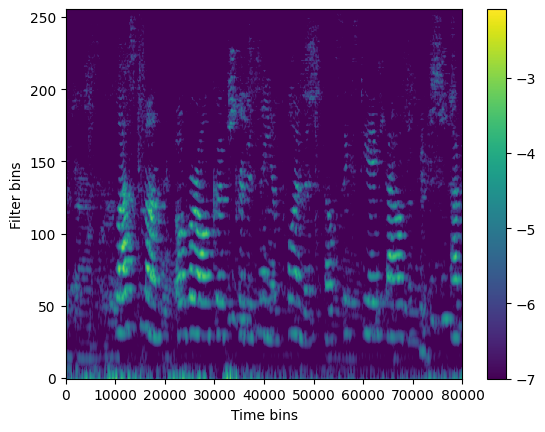

In [40]:
x_pad = F.pad(x, (T//2, T//2), mode='circular')
x_fir = x_pad.unsqueeze(1)

filterbank = hybra_r.unsqueeze(1)

x_real = F.conv1d(x_fir, torch.real(filterbank), stride=1, padding='valid').squeeze(1)
x_mag = x_real**2

plt.imshow(np.log10(x_mag.numpy()[0,:,:]), vmin=-7, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')

x_tilde = F.conv_transpose1d(x_real, torch.real(filterbank), stride=1, padding=T//2).squeeze(0)

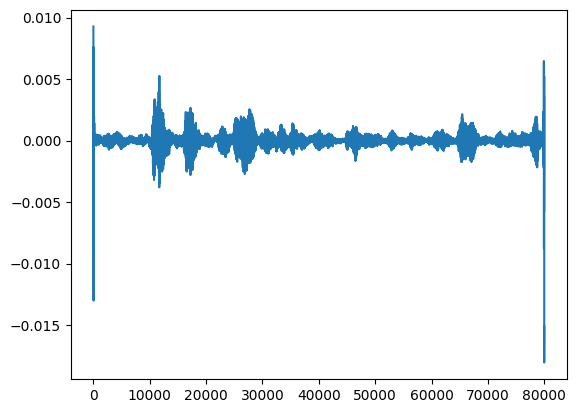

In [41]:
plt.plot(x.T.numpy() - x_tilde.T.numpy(), label='difference')

In [ ]:
F.pad(aud_tight_fir, (T_random//2, T_random//2), mode='circulant').shape

In [42]:
# hybra filterbank

hybra_real = F.conv1d(torch.real(aud_tight_fir.unsqueeze(0)), random_tight_fir.unsqueeze(1), stride=1, groups=J, padding='same').squeeze(0)
hybra_imag = F.conv1d(torch.imag(aud_tight_fir.unsqueeze(0)), random_tight_fir.unsqueeze(1), stride=1, groups=J, padding='same').squeeze(0)
hybra = hybra_real + 1j * hybra_imag

#hybra_tight = fir_tightener3000(torch.cat([hybra, torch.zeros(J,N-T)], dim=1), 512, eps=1.01)
#hybra_tight_fir = hybra_tight[:, :T]

print(calculate_condition_number(hybra))

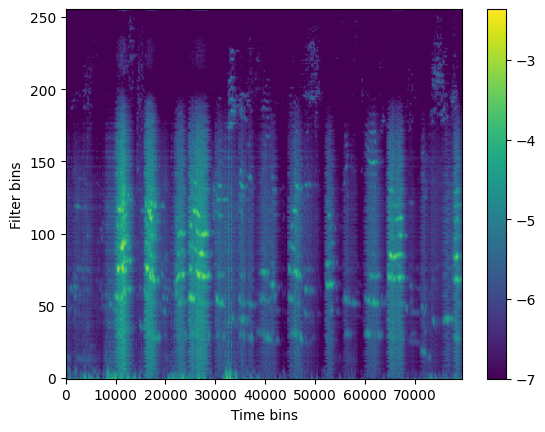

In [81]:
x_pad = F.pad(x, (T//2, T//2), mode='circular')
x_fir = x_pad.unsqueeze(1)

filterbank = hybra.unsqueeze(1)

x_real = F.conv1d(x_fir, torch.real(filterbank), stride=1, padding=0)
x_imag = F.conv1d(x_fir, torch.imag(filterbank), stride=1, padding=0)
x_mag = x_real**2 + x_imag**2

plt.imshow(np.log10(x_mag.numpy()[0,:,:]), vmin=-7, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')

x_tilde_real = F.conv_transpose1d(x_real, torch.real(filterbank), stride=1, padding=T//2).squeeze(0)
x_tilde_imag = F.conv_transpose1d(x_imag, torch.imag(filterbank), stride=1, padding=T//2).squeeze(0)

x_tilde = x_tilde_real + x_tilde_imag

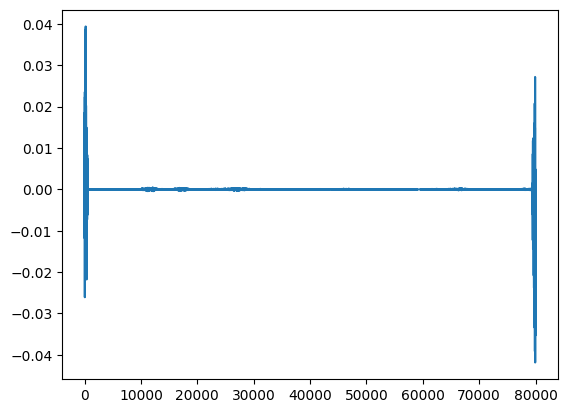

In [82]:
# reconstruction error
plt.plot(x.T.numpy() - x_tilde.T.numpy(), label='difference')
#plt.plot(x.T.numpy())
#plt.plot(x_tilde.T.numpy()*1.45)

In [ ]:
# initialize learned filterbank Phi
supp_Phi = 23

W_random = random_filterbank(supp_ran, num_filters, supp_ran, norm=False, tight=False, to_torch=False, support_only=True)
W_random = fir_tightener3000(W_random, supp_ran)
W_random_tensor = torch.tensor(W_random, dtype=torch.float32).unsqueeze(1)

In [3]:
filterbank = HybrA(path_to_auditory_filter_config="auditory_filters_speech.pth")

signal.shape

torch.Size([1, 80000])

dict_keys(['auditory_filters_real', 'auditory_filters_imag', 'auditory_filters_stride', 'n_filters', 'kernel_size'])

In [ ]:
weights = torch.load("aud_bias_final_400.pth", map_location="cpu")['model_state_dict']['filterbank.encoder.weight']

filterbank.encoder.weight = torch.nn.Parameter(weights)

torch.Size([1, 256, 622])


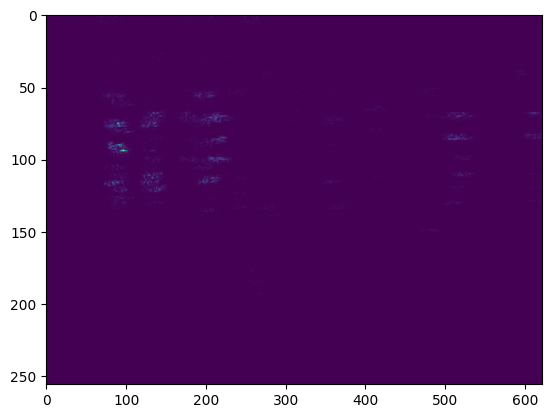

In [10]:
response = filterbank(signal)
print(response.shape)
plt.imshow(response.detach().numpy()[0], aspect='auto')

plt.show()